In [19]:
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

import matplotlib.pyplot as plt
import numpy as np
import itertools
# from encoder_ import *

In [20]:
# dataloader arguments
batch_size = 128
data_path='./data'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [ ]:
scaler = GradScaler()

In [21]:
# Define a transform
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
# Create DataLoaders
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [23]:
num_inputs = 32*32
num_hidden = 1000
num_outputs = 10

num_steps = 25

spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5

In [24]:
net = nn.Sequential(nn.Linear(num_inputs, num_hidden),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Linear(num_hidden, num_outputs),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [25]:
time_window = 100
fire_window_ratio = 0.2

In [67]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)

  spike_trains = spikegen.rate(data, num_steps, gain=1)
  spike_trains = torch.mean(spike_trains, dim=2, keepdim=True)
  spike_trains = spike_trains.squeeze()

  for step in range(num_steps):
      spk_out, mem_out = net(spike_trains[step].view(batch_size, -1))
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [68]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [69]:
loss_fn = SF.ce_rate_loss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [70]:
num_epochs = 1
num_steps = time_window
loss_hist = []
test_acc_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        # spk_rec, mem_rec = net(data.view(batch_size, -1))
        with autocast():
            spk_rec, _ = forward_pass(net, num_steps, data)
            loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter % 50 == 0:
            with torch.no_grad():
                net.eval()

                # Test set forward pass
                test_acc = batch_accuracy(test_loader, net, num_steps)
                print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
                test_acc_hist.append(test_acc.item())

        counter += 1

Iteration 0, Test Acc: 9.33%

Iteration 50, Test Acc: 18.06%

Iteration 100, Test Acc: 20.36%

Iteration 150, Test Acc: 24.22%

Iteration 200, Test Acc: 26.34%



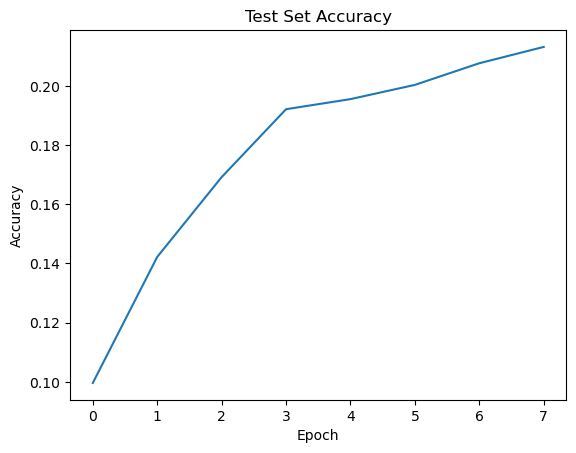

In [ ]:
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
def forward_pass_test(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data.view(data.size(0), -1))
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [ ]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = forward_pass_test(net, num_steps, data)

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

NameError: name 'mnist_test' is not defined

In [ ]:
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9300/10000
Test Set Accuracy: 93.00%
